From here I'm using the Toppic all prsm file as a 'hit report', and matching which file names and according scan number are in td_auditor topFD by msn, and adding a column of whether it hits or not 

In [6]:
import pandas as pd


# Load the dataset
file_path = "20241108-1551-TopPIC-FullDB-all_prsm_single.tsv"  # Update with correct file path
df_prsm_hit_topfd = pd.read_csv(file_path, sep="\t", skiprows=43, engine="python", dtype=str)

# Check the first few rows to ensure it loaded correctly
print(df_prsm_hit_topfd.head())





                                      Data file name Prsm ID Spectrum ID  \
0  06102019_RVG262_PLRPS_FAIMS_CV__F1_CD3_0L_Neg1...       0         153   
1  06102019_RVG262_PLRPS_FAIMS_CV__F1_CD3_0L_Neg1...       1         156   
2  06102019_RVG262_PLRPS_FAIMS_CV__F1_CD3_0L_Neg1...       2         159   
3  06102019_RVG262_PLRPS_FAIMS_CV__F1_CD3_0L_Neg1...       3         160   
4  06102019_RVG262_PLRPS_FAIMS_CV__F1_CD3_0L_Neg1...       4         161   

  Fragmentation Scan(s) Retention time #peaks Charge Precursor mass  \
0           HCD     257         715.81     55      3     3352.78825   
1           HCD     261         727.93     90     26    22246.30313   
2           HCD     266         740.90    100      4     3869.14105   
3           HCD     267         743.00    189     18     19123.3995   
4           HCD     269         747.43    223     16    19123.39942   

  Adjusted precursor mass  ... #unexpected modifications  \
0             3352.782648  ...                         0

In [4]:
# Load the TDAuditor dataset
tdauditor_file_path = "/Users/user/PycharmProjects/TDAuditor/20250430-TDAuditor-TSVs-TopFD-FLASH-PSPDXtract/TDAuditor-TopFD-byMSn.tsv"  # Update with actual path
tdauditor_topfd = pd.read_csv(tdauditor_file_path, delimiter="\t")
print(tdauditor_topfd.head())
# Extract the filenames from TDAuditor
tdauditor_filenames = set(tdauditor_topfd["SourceFile"])  # Update column name
print(len(tdauditor_filenames))

                                     SourceFile  \
0  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   

                                       NativeID  ScanNumber  ScanStartTime  \
0   controllerType=0 controllerNumber=1 scan=21          21       0.681169   
1   controllerType=0 controllerNumber=1 scan=83          83       2.624363   
2   controllerType=0 controllerNumber=1 scan=96          96       3.050480   
3  controllerType=0 controllerNumber=1 scan=112         112       3.569240   
4  controllerType=0 controllerNumber=1 scan=202         202       6.378995   

  mzMLDissociation  MatchedToDeconvolution  mzMLPreZ  mzMLSelectedIon  \
0              HCD                    True         1       775.334290   
1              HCD                    True         3       775.301880   
2    

In [7]:
print(df_prsm_hit_topfd.columns)


Index(['Data file name', 'Prsm ID', 'Spectrum ID', 'Fragmentation', 'Scan(s)',
       'Retention time', '#peaks', 'Charge', 'Precursor mass',
       'Adjusted precursor mass', 'Proteoform ID', 'Proteoform intensity',
       'Feature ID', 'Feature intensity', 'Feature score', 'Feature apex time',
       '#Protein hits', 'Protein accession', 'Protein description',
       'First residue', 'Last residue', 'Special amino acids',
       'Database protein sequence', 'Proteoform', 'Proteoform mass',
       'Protein N-terminal form', 'Fixed PTMs', '#unexpected modifications',
       'unexpected modifications', '#variable PTMs', 'variable PTMs',
       'MIScore', '#matched peaks', '#matched fragment ions', 'E-value',
       'Spectrum-level Q-value', 'Proteoform-level Q-value'],
      dtype='object')


In [8]:
def clean_filename(filename):
    # Remove '_ms2.msalign'
    filename = filename.replace("_ms2.msalign", "")
    
    # Ensure the filename matches the closest TDAuditor entry
    for tdauditor_file in tdauditor_filenames:
        if tdauditor_file in filename:
            return tdauditor_file  # Replace with the correct match
    
    return filename  # Return the cleaned filename if no match found


In [9]:
df_prsm_hit_topfd["Cleaned SourceFile"] = df_prsm_hit_topfd["Data file name"].apply(clean_filename)

# Verify the changes
#print(df_prsm_hit["Cleaned SourceFile"].unique())


In [10]:
unmatched_filenames = set(df_prsm_hit_topfd["Cleaned SourceFile"]) - tdauditor_filenames
print("Unmatched Filenames:", unmatched_filenames)


Unmatched Filenames: set()


In [11]:


# Ensure scan numbers are treated as strings
df_prsm_hit_topfd["Scan(s)"] = df_prsm_hit_topfd["Scan(s)"].astype(str)
tdauditor_topfd["ScanNumber"] = tdauditor_topfd["ScanNumber"].astype(str)

# Create a set of matching (SourceFile, Scan) pairs from df_prsm_hit
matching_pairs = set(zip(df_prsm_hit_topfd["Cleaned SourceFile"], df_prsm_hit_topfd["Scan(s)"]))

# Add the hit column to TDAuditor
tdauditor_topfd["hit"] = tdauditor_topfd.apply(
    lambda row: 1 if (row["SourceFile"], row["ScanNumber"]) in matching_pairs else 0, 
    axis=1
)

# Save the updated file
output_path = "topfd_td_auditor_hit_column.tsv"
tdauditor_topfd.to_csv(output_path, sep="\t", index=False)

# Print check
print(tdauditor_topfd)

                                           SourceFile  \
0        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
...                                               ...   
2782373             RM_20190929_cyto_eosinophil_F4_02   
2782374             RM_20190929_cyto_eosinophil_F4_02   
2782375             RM_20190929_cyto_eosinophil_F4_02   
2782376             RM_20190929_cyto_eosinophil_F4_02   
2782377             RM_20190929_cyto_eosinophil_F4_02   

                                              NativeID ScanNumber  \
0          controllerType=0 controllerNumber=1 scan=21         21   
1          controllerType=0 controllerNumber=1 scan=83         83   
2          controllerType=0 controllerNumber=1 scan=96         96   
3         controllerType=0 controllerNu

In [21]:
print((tdauditor_topfd['hit'] == 1).sum())

685024


In [23]:
print((tdauditor_topfd['hit'] == 0).sum())

2097354


In [25]:
print((tdauditor_topfd['mzMLDissociation'] == "HCD").sum())

2158510


In [26]:
print((tdauditor_topfd['mzMLDissociation'] != "HCD").sum())

623868


In [16]:
tdauditor_topfd.describe()

,ScanStartTime,mzMLPreZ,DeconvPreZ,DeconvPreMass,mzMLPeakCount,DeconvPeakCount,Degree,ComponentNumber,AALinkCount,LongestTag,hit
count,2.782378e+06,2.782378e+06,2.782378e+06,2.723228e+06,2.782378e+06,2.782378e+06,2.782378e+06,2.782378e+06,2.782378e+06,2.782378e+06,2.782378e+06
mean,4.660336e+01,7.948066e+00,8.904746e+00,8.626821e+03,2.108460e+03,8.910103e+01,1.455243e+01,1.403453e+03,2.508127e+01,3.102851e+00,2.462009e-01
std,2.640478e+01,8.684573e+00,7.149013e+00,6.687623e+03,2.590528e+03,9.742472e+01,6.799758e+01,3.473647e+03,4.486096e+01,3.545529e+00,4.307970e-01
min,1.146161e-02,0.000000e+00,0.000000e+00,4.995114e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.678855e+01,0.000000e+00,2.000000e+00,2.838463e+03,5.960000e+02,1.100000e+01,0.000000e+00,1.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.258805e+01,6.000000e+00,7.000000e+00,7.523749e+03,1.433000e+03,5.700000e+01,0.000000e+00,4.200000e+02,7.000000e+00,2.000000e+00,0.000000e+00
75%,6.250180e+01,1.200000e+01,1.400000e+01,1.264026e+04,2.606000e+03,1.370000e+02,1.000000e+00,9.460000e+02,3.100000e+01,5.000000e+00,0.000000e+00
max,1.800746e+02,9.500000e+01,3.000000e+01,4.752713e+04,3.681400e+04,7.410000e+02,1.045000e+03,2.571200e+04,1.196000e+03,3.900000e+01,1.000000e+00


Now I will be repeating what I did in the last chunk but for TopFD using the prsm file specifically for FlashDeconv

In [12]:
import pandas as pd
# Load the dataset
file_path_2 = "20250213-1551-FLASH-TopPIC-FullDB-all_prsm_single.tsv"  # Update with correct file path
df_prsm_hit_flash = pd.read_csv(file_path_2, sep="\t", skiprows=43, engine="python", dtype=str)

# Check the first few rows to ensure it loaded correctly
#print(df_prsm_hit_flash.head())

In [13]:
# Load the TDAuditor dataset
tdauditor_file_2 = "/Users/user/PycharmProjects/TDAuditor/20250430-TDAuditor-TSVs-TopFD-FLASH-PSPDXtract/TDAuditor-FLASHDeconv-byMSn.tsv"  # Update with actual path
tdauditor_flash = pd.read_csv(tdauditor_file_2, delimiter="\t")
print(tdauditor_flash.head())
# Extract the filenames from TDAuditor
tdauditor_filenames_f = set(tdauditor_flash["SourceFile"])  # Update column name
print(tdauditor_filenames_f)

                                     SourceFile  \
0  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   

                                       NativeID  ScanNumber  ScanStartTime  \
0   controllerType=0 controllerNumber=1 scan=21          21       0.681169   
1   controllerType=0 controllerNumber=1 scan=83          83       2.624363   
2   controllerType=0 controllerNumber=1 scan=96          96       3.050480   
3  controllerType=0 controllerNumber=1 scan=112         112       3.569240   
4  controllerType=0 controllerNumber=1 scan=202         202       6.378995   

  mzMLDissociation  MatchedToDeconvolution  mzMLPreZ  mzMLSelectedIon  \
0              HCD                   False         1       775.334290   
1              HCD                   False         3       775.301880   
2    

In [14]:
def clean_filename_flash(filename):
    # Remove '_ms2.msalign'
    filename = filename.replace("_ms2.msalign", "")
    
    # Ensure the filename matches the closest TDAuditor entry
    for tdauditor_file in tdauditor_filenames_f:
        if tdauditor_file in filename:
            return tdauditor_file  # Replace with the correct match
    
    return filename  # Return the cleaned filename if no match found


In [15]:
df_prsm_hit_flash["Cleaned SourceFile"] = df_prsm_hit_flash["Data file name"].apply(clean_filename_flash)

unmatched_filenames = set(df_prsm_hit_flash["Cleaned SourceFile"]) - tdauditor_filenames_f
print("Unmatched Filenames:", unmatched_filenames)


Unmatched Filenames: set()


In [16]:


# Ensure scan numbers are treated as strings
df_prsm_hit_flash["Scan(s)"] = df_prsm_hit_flash["Scan(s)"].astype(str)
tdauditor_flash["ScanNumber"] = tdauditor_flash["ScanNumber"].astype(str)

# Create a set of matching (SourceFile, Scan) pairs from df_prsm_hit
matching_pairs = set(zip(df_prsm_hit_flash["Cleaned SourceFile"], df_prsm_hit_flash["Scan(s)"]))

# Add the hit column to TDAuditor
tdauditor_flash["hit"] = tdauditor_flash.apply(
    lambda row: 1 if (row["SourceFile"], row["ScanNumber"]) in matching_pairs else 0, 
    axis=1
)

# Save the updated file
output_path = "flash_td_auditor_hit_column.tsv"
tdauditor_flash.to_csv(output_path, sep="\t", index=False)



725391
Instrument
Q Exactive               0.468750
Orbitrap Fusion Lumos    0.282323
LTQ Orbitrap Elite       0.273725
Orbitrap Eclipse         0.232271
LTQ FT Ultra             0.187841
Name: hit, dtype: float64


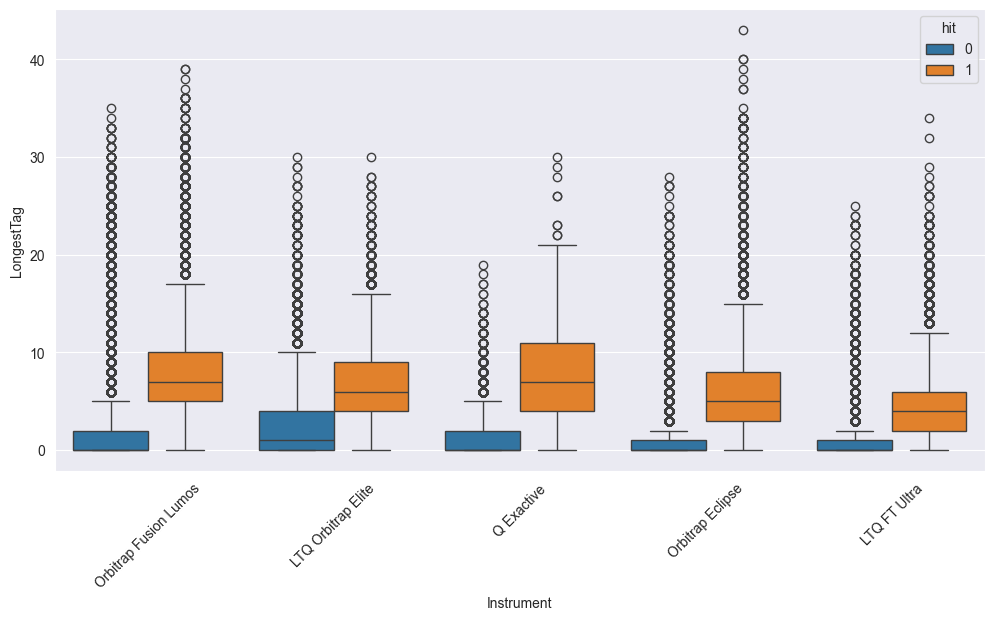

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
#tdauditor_flash = pd.read_csv("updated_td_auditor_flashdeconv_with_instrument.tsv", sep="\t")
print((tdauditor_flash['hit'] == 1).sum())
print(tdauditor_flash.groupby('Instrument')['hit'].mean().sort_values(ascending=False))

# Or visualize instrument effects:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=tdauditor_flash, x='Instrument', y='LongestTag', hue='hit')
plt.xticks(rotation=45)
plt.show()

In [7]:
print((tdauditor_flash['hit'] == 0).sum())

2056987


/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_72259/3407409471.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  tdauditor_topfd = pd.read_csv("updated_td_auditor_topfd_with_instrument.tsv", sep="\t")


685024
Instrument
Q Exactive               0.484859
LTQ Orbitrap Elite       0.277203
Orbitrap Fusion Lumos    0.270139
Orbitrap Eclipse         0.203086
LTQ FT Ultra             0.179480
Name: hit, dtype: float64


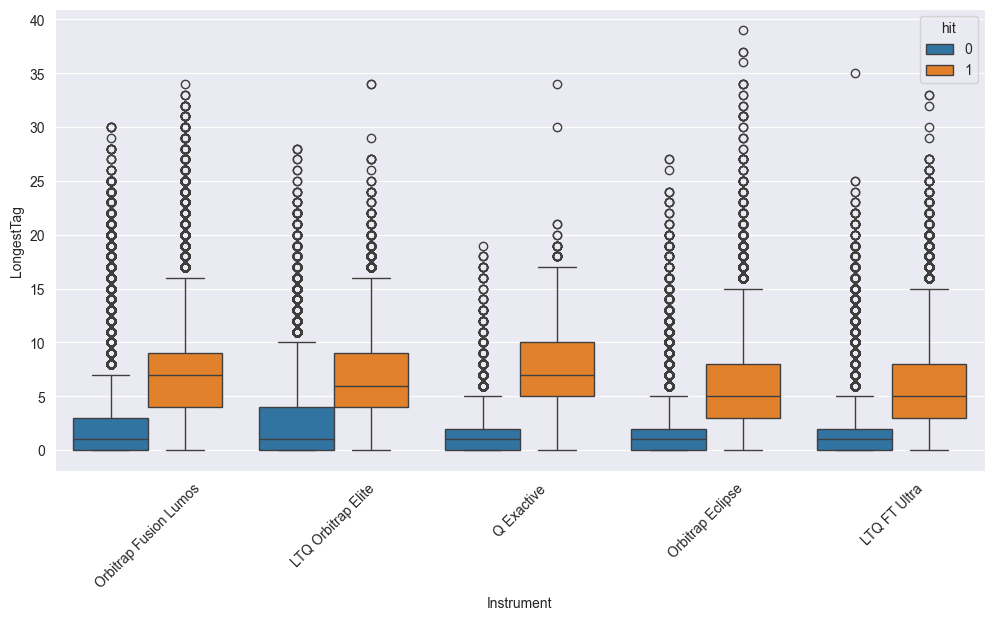

In [14]:

tdauditor_topfd = pd.read_csv("updated_td_auditor_topfd_with_instrument.tsv", sep="\t")
print((tdauditor_topfd['hit']==1).sum())
# You could analyze hit rates by instrument:
print(tdauditor_topfd.groupby('Instrument')['hit'].mean().sort_values(ascending=False))

# Or visualize instrument effects:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(data=tdauditor_topfd, x='Instrument', y='LongestTag', hue='hit')
plt.xticks(rotation=45)
plt.show()

In [3]:
print((tdauditor_topfd['hit'] == 0).sum())

2097354


In [36]:
import pandas as pd

# Load the datasets
topfd_df = pd.read_csv("/Users/user/PycharmProjects/TDAuditor/20250214-TDAuditor-Reports-FLASH-and-TopFD/20250214-TopFD178-TDAuditor-byMSn.tsv", delimiter="\t")  # Replace with actual file name
flashdeconv_df = pd.read_csv("/Users/user/PycharmProjects/TDAuditor/20250214-TDAuditor-Reports-FLASH-and-TopFD/20250214-FLASHDeconv-TDAuditor-byMSn.tsv", delimiter="\t")  # Replace with actual file name

# Select only relevant columns
topfd_df = topfd_df[['SourceFile', 'ScanNumber']]
flashdeconv_df = flashdeconv_df[['SourceFile', 'ScanNumber']]

# Merge on SourceFile & ScanNumber to find matches
merged_df = pd.merge(topfd_df, flashdeconv_df, on=['SourceFile', 'ScanNumber'], how='inner')

# Calculate match percentage
total_scans_topfd = len(topfd_df)
total_scans_flashdeconv = len(flashdeconv_df)
total_matches = len(merged_df)

match_percentage_topfd = (total_matches / total_scans_topfd) * 100
match_percentage_flashdeconv = (total_matches / total_scans_flashdeconv) * 100

# Print results
print(f"Total scans in TopFD: {total_scans_topfd}")
print(f"Total scans in FlashDeconv: {total_scans_flashdeconv}")
print(f"Total matching scans: {total_matches}")
print(f"Match percentage (TopFD-based): {match_percentage_topfd:.2f}%")
print(f"Match percentage (FlashDeconv-based): {match_percentage_flashdeconv:.2f}%")


Total scans in TopFD: 2782378
Total scans in FlashDeconv: 2782378
Total matching scans: 2782378
Match percentage (TopFD-based): 100.00%
Match percentage (FlashDeconv-based): 100.00%


Now I am adding the intrument type to each of the updated td_auditor files for top_fd and flash_deconv

In [17]:
import pandas as pd

# Load the instrument type file
instrument_df_flash = pd.read_csv("/Users/user/PycharmProjects/TDAuditor/20250430-TDAuditor-TSVs-TopFD-FLASH-PSPDXtract/TDAuditor-FLASHDeconv-byRun.tsv", delimiter="\t")  # Update filename & delimiter if needed
instrument_df_top = pd.read_csv("/Users/user/PycharmProjects/TDAuditor/20250430-TDAuditor-TSVs-TopFD-FLASH-PSPDXtract/TDAuditor-TopFD-byRun.tsv", delimiter="\t")  # Update filename & delimiter if needed

instrument_df_top = instrument_df_top[["SourceFile", "Instrument"]]
instrument_df_flash = instrument_df_flash[["SourceFile", "Instrument"]]

# Load the updated td_auditor files
td_auditor_topfd = pd.read_csv("topfd_td_auditor_hit_column.tsv", delimiter="\t")
td_auditor_flashdeconv = pd.read_csv("flash_td_auditor_hit_column.tsv", delimiter="\t")

# Merge instrument type with both datasets
td_auditor_topfd = td_auditor_topfd.merge(instrument_df_top, on="SourceFile", how="left")
td_auditor_flashdeconv = td_auditor_flashdeconv.merge(instrument_df_flash, on="SourceFile", how="left")

# Save updated files if needed
td_auditor_topfd.to_csv("tdauditor_topfd_with_instrument.tsv", sep="\t", index=False)
td_auditor_flashdeconv.to_csv("tdauditor_flashdeconv_with_instrument.tsv", sep="\t", index=False)

# Check if everything looks good
print(td_auditor_topfd.head())
print(td_auditor_flashdeconv.head())


                                     SourceFile  \
0  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   

                                       NativeID  ScanNumber  ScanStartTime  \
0   controllerType=0 controllerNumber=1 scan=21          21       0.681169   
1   controllerType=0 controllerNumber=1 scan=83          83       2.624363   
2   controllerType=0 controllerNumber=1 scan=96          96       3.050480   
3  controllerType=0 controllerNumber=1 scan=112         112       3.569240   
4  controllerType=0 controllerNumber=1 scan=202         202       6.378995   

  mzMLDissociation  MatchedToDeconvolution  mzMLPreZ  mzMLSelectedIon  \
0              HCD                    True         1       775.334290   
1              HCD                    True         3       775.301880   
2    

In [3]:
import pandas as pd

tdauditor_topfd = pd.read_csv('tdauditor_topfd_with_instrument.tsv', delimiter="\t")
tdauditor_flash = pd.read_csv('tdauditor_flashdeconv_with_instrument.tsv', delimiter="\t")



/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_75328/2465501291.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  tdauditor_topfd = pd.read_csv('tdauditor_topfd_with_instrument.tsv', delimiter="\t")
/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_75328/2465501291.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  tdauditor_flash = pd.read_csv('tdauditor_flashdeconv_with_instrument.tsv', delimiter="\t")


In [4]:
tdauditor_topfd.head()

,SourceFile,NativeID,ScanNumber,ScanStartTime,mzMLDissociation,MatchedToDeconvolution,mzMLPreZ,mzMLSelectedIon,mzMLMassResolvingPower,DeconvPreZ,DeconvPreMass,mzMLPeakCount,DeconvPeakCount,Degree,ComponentNumber,AALinkCount,LongestTag,hit,Instrument
0,06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3,controllerType=0 controllerNumber=1 scan=21,21,0.681169,HCD,True,1,775.334290,60000,1,774.32859,14,0,0,0,0,0,0,Orbitrap Fusion Lumos
1,06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3,controllerType=0 controllerNumber=1 scan=83,83,2.624363,HCD,True,3,775.301880,60000,3,2321.88400,21,0,0,0,0,0,0,Orbitrap Fusion Lumos
2,06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3,controllerType=0 controllerNumber=1 scan=96,96,3.050480,HCD,True,2,731.344910,60000,1,730.33763,19,0,0,0,0,0,0,Orbitrap Fusion Lumos
3,06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3,controllerType=0 controllerNumber=1 scan=112,112,3.569240,HCD,True,1,1093.244995,60000,1,1092.23772,19,0,0,0,0,0,0,Orbitrap Fusion Lumos
4,06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3,controllerType=0 controllerNumber=1 scan=202,202,6.378995,HCD,True,2,775.260071,60000,2,1548.50361,22,0,0,0,0,0,0,Orbitrap Fusion Lumos


In [10]:

print("HCD =", (tdauditor_topfd['mzMLDissociation'] == 'HCD').sum())
print('ETD =', (tdauditor_topfd['mzMLDissociation'] == 'ETD').sum())
print('CID =', (tdauditor_topfd['mzMLDissociation'] == 'CID').sum())

HCD = 2158510
ETD = 32787
CID = 591081


In [3]:
import pandas as pd


# Load the dataset
file_path = "20200811-Published-Identifications_Hit-Report-Sorted.xlsx"  # Update with correct file path
df_prsm_hit_pro = pd.read_excel(file_path)

# Check the first few rows to ensure it loaded correctly
print(df_prsm_hit_pro.head())

    HitId      PFR   Accession  \
0  762243    20722      P16402   
1     122  4904212  A0A2R8Y619   
2     176  5124760    P22626-2   
3     184  4980577    P22626-2   
4     206  4980587    P22626-1   

                                      Description  \
0      Histone H1.3 (Histone H1c) (Histone H1s-2)   
1                           Histone H2B type 2-E1   
2  Heterogeneous nuclear ribonucleoproteins A2/B1   
3  Heterogeneous nuclear ribonucleoproteins A2/B1   
4  Heterogeneous nuclear ribonucleoproteins A2/B1   

                                            Sequence  Start Index  End Index  \
0  SETAPLAPTIPAPAEKTPVKKKAKKAGATAGKRKASGPPVSELITK...            2        221   
1               TSREVQTAVRLLLPGELAKHAVSEGTKAVTKYTSSK           87        122   
2  DDHDPVDKIVLQKYHTINGHNAEVRKALSRQEMQEVQSSRSGRGGN...          149        341   
3  DDHDPVDKIVLQKYHTINGHNAEVRKALSRQEMQEVQSSRSGRGGN...          149        341   
4  DHDPVDKIVLQKYHTINGHNAEVRKALSRQEMQEVQSSRSGRGGNF...          162        353

In [5]:
# Load the TDAuditor dataset
tdauditor_pro_file_path = "/Users/user/PycharmProjects/TDAuditor/20250430-TDAuditor-TSVs-TopFD-FLASH-PSPDXtract/TDAuditor-PSPDXtract-byMSn.tsv"  # Update with actual path
tdauditor_pro = pd.read_csv(tdauditor_pro_file_path, delimiter="\t")
print(tdauditor_pro.head())
# Extract the filenames from TDAuditor
tdauditor_filenames = set(tdauditor_pro["SourceFile"])  # Update column name
print(len(tdauditor_filenames))

                                     SourceFile  \
0  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   

                                       NativeID  ScanNumber  ScanStartTime  \
0   controllerType=0 controllerNumber=1 scan=21          21       0.681169   
1   controllerType=0 controllerNumber=1 scan=83          83       2.624363   
2   controllerType=0 controllerNumber=1 scan=96          96       3.050480   
3  controllerType=0 controllerNumber=1 scan=112         112       3.569240   
4  controllerType=0 controllerNumber=1 scan=202         202       6.378995   

  mzMLDissociation  MatchedToDeconvolution  mzMLPreZ  mzMLSelectedIon  \
0              HCD                   False         1       775.334290   
1              HCD                   False         3       775.301880   
2    

In [10]:
def clean_filename(filename):
    # Remove '_ms2.msalign'
    filename = filename.replace(".raw", "")
    # Replace '+' with '_' for comparison
    filename = filename.replace("+", "_")

    # Ensure the filename matches the closest TDAuditor entry
    for tdauditor_file in tdauditor_filenames:
        if tdauditor_file in filename:
            return tdauditor_file  # Replace with the correct match

    return filename  # Return the cleaned filename if no match found


df_prsm_hit_pro["Cleaned SourceFile"] = df_prsm_hit_pro["File Name"].apply(clean_filename)



In [11]:

unmatched_filenames = set(df_prsm_hit_pro["Cleaned SourceFile"]) - tdauditor_filenames
print("Unmatched Filenames:", unmatched_filenames)


Unmatched Filenames: set()


In [13]:
# Ensure scan numbers are treated as strings
df_prsm_hit_pro["Fragment Scans"] = df_prsm_hit_pro["Fragment Scans"].astype(str)
tdauditor_pro["ScanNumber"] = tdauditor_pro["ScanNumber"].astype(str)

# Create a set of matching (SourceFile, Scan) pairs from df_prsm_hit
matching_pairs = set(zip(df_prsm_hit_pro["Cleaned SourceFile"], df_prsm_hit_pro["Fragment Scans"]))

# Add the hit column to TDAuditor
tdauditor_pro["hit"] = tdauditor_pro.apply(
    lambda row: 1 if (row["SourceFile"], row["ScanNumber"]) in matching_pairs else 0,
    axis=1
)

# Save the updated file
output_path = "pro_td_auditor_hit_column.tsv"

In [14]:
print((tdauditor_pro['hit'] == 1).sum())
print((tdauditor_pro['hit'] == 0).sum())

364242
2418136


In [15]:
tdauditor_pro.to_csv(output_path, sep="\t", index=False)

In [16]:
import pandas as pd

# Load the instrument type file
instrument_df_pro = pd.read_csv("/Users/user/PycharmProjects/TDAuditor/20250430-TDAuditor-TSVs-TopFD-FLASH-PSPDXtract/TDAuditor-PSPDXtract-byRun.tsv", delimiter="\t")  

instrument_df_pro = instrument_df_pro[["SourceFile", "Instrument"]]

# Load the updated td_auditor files
td_auditor_pro = pd.read_csv("pro_td_auditor_hit_column.tsv", delimiter="\t")

# Merge instrument type with both datasets
td_auditor_pro = td_auditor_pro.merge(instrument_df_pro, on="SourceFile", how="left")

# Save updated files if needed
td_auditor_pro.to_csv("tdauditor_pro_with_instrument.tsv", sep="\t", index=False)

# Check if everything looks good
print(td_auditor_pro.head())


                                     SourceFile  \
0  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4  06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   

                                       NativeID  ScanNumber  ScanStartTime  \
0   controllerType=0 controllerNumber=1 scan=21          21       0.681169   
1   controllerType=0 controllerNumber=1 scan=83          83       2.624363   
2   controllerType=0 controllerNumber=1 scan=96          96       3.050480   
3  controllerType=0 controllerNumber=1 scan=112         112       3.569240   
4  controllerType=0 controllerNumber=1 scan=202         202       6.378995   

  mzMLDissociation  MatchedToDeconvolution  mzMLPreZ  mzMLSelectedIon  \
0              HCD                   False         1       775.334290   
1              HCD                   False         3       775.301880   
2    

In [3]:
import pandas as pd
top = pd.read_csv("tdauditor_topfd_with_instrument.tsv", sep="\t")
print(top)

/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_67291/3731241984.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  top = pd.read_csv("tdauditor_topfd_with_instrument.tsv", sep="\t")


                                           SourceFile  \
0        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
1        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
2        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
3        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
4        06102019_RVG262_PLRPS_FAIMS_CV_Neg100_F1_CD3   
...                                               ...   
2782373             RM_20190929_cyto_eosinophil_F4_02   
2782374             RM_20190929_cyto_eosinophil_F4_02   
2782375             RM_20190929_cyto_eosinophil_F4_02   
2782376             RM_20190929_cyto_eosinophil_F4_02   
2782377             RM_20190929_cyto_eosinophil_F4_02   

                                              NativeID  ScanNumber  \
0          controllerType=0 controllerNumber=1 scan=21          21   
1          controllerType=0 controllerNumber=1 scan=83          83   
2          controllerType=0 controllerNumber=1 scan=96          96   
3         controllerType=0 controll

In [9]:
pro = pd.read_csv("tdauditor_pro_with_instrument.tsv", sep="\t")

pro['Instrument'] = pro['Instrument'].fillna('Orbitrap Eclipse')
# Print total samples per instrument
print(pro['Instrument'].value_counts())


/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_67291/2894155158.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  pro = pd.read_csv("tdauditor_pro_with_instrument.tsv", sep="\t")


Instrument
Orbitrap Fusion Lumos    1614586
LTQ FT Ultra              623868
Orbitrap Eclipse          457222
LTQ Orbitrap Elite         75342
Q Exactive                 11360
Name: count, dtype: int64


In [10]:

flash = pd.read_csv("tdauditor_flashdeconv_with_instrument.tsv", sep="\t")

print(flash['mzMLDissociation'].value_counts())


/var/folders/j6/_f4gqc7j33nb2dzqnzm9w2w00000gn/T/ipykernel_67291/746429999.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  flash = pd.read_csv("tdauditor_flashdeconv_with_instrument.tsv", sep="\t")


mzMLDissociation
HCD    2158510
CID     591081
ETD      32787
Name: count, dtype: int64


In [17]:
# Count number of hits (Hit == 1) per instrument
hit_counts = flash[flash['hit'] == 1].groupby('mzMLDissociation').size()

print(hit_counts)


mzMLDissociation
CID    112595
ETD      4593
HCD    607486
dtype: int64


In [18]:
# Count number of hits (Hit == 1) per instrument
hit_counts_p = pro[pro['hit'] == 1].groupby('mzMLDissociation').size()

print(hit_counts_p)




mzMLDissociation
CID     96491
ETD      3511
HCD    264240
dtype: int64


In [19]:
# Count number of hits (Hit == 1) per instrument
hit_counts_t = top[top['hit'] == 1].groupby('mzMLDissociation').size()

print(hit_counts_t)

mzMLDissociation
CID    107383
ETD      4589
HCD    572777
dtype: int64
